# Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from typing import List, Union
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [115]:
!unzip '/content/drive/MyDrive/Colab Notebooks/SW_Rasengan/train1000.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/SW_Rasengan/train1000.zip
  inflating: submit_20.csv           
  inflating: test_20.csv             
  inflating: test_img/TEST_00000.png  
  inflating: test_img/TEST_00001.png  
  inflating: test_img/TEST_00002.png  
  inflating: test_img/TEST_00003.png  
  inflating: test_img/TEST_00004.png  
  inflating: test_img/TEST_00005.png  
  inflating: test_img/TEST_00006.png  
  inflating: test_img/TEST_00007.png  
  inflating: test_img/TEST_00008.png  
  inflating: test_img/TEST_00009.png  
  inflating: test_img/TEST_00010.png  
  inflating: test_img/TEST_00011.png  
  inflating: test_img/TEST_00012.png  
  inflating: test_img/TEST_00013.png  
  inflating: test_img/TEST_00014.png  
  inflating: test_img/TEST_00015.png  
  inflating: test_img/TEST_00016.png  
  inflating: test_img/TEST_00017.png  
  inflating: test_img/TEST_00018.png  
  inflating: test_img/TEST_00019.png  
  inflating: train_1000.csv          
  inflating: train_img/TRAIN_00

In [2]:
config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'base_path': '/', # change relative path of data
    #'train_data': 'zeroto20.csv', # change train data csv name
    'train_data': 'train_1000.csv', # change train data csv name
    'test_data': 'test_20.csv', # change test data csv name
    'seed': 42,
    'valid_size': 0.1,
    'early_stopping': 15,
    'scheduler': True,
    'train' : {
       'batch_size' : 16,
       'num_workers': 1,
       'epochs': 100,
       'lr': 0.0005,
    },
    'inference' : {
       'batch_size' : 8,
       'num_workers': 1,
       'threshold': 0.35,
    },
}

custom_transform = {
    'train':A.Compose([
        A.augmentations.crops.transforms.RandomCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'valid':A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224,p=1.0),
        A.Normalize(),
        ToTensorV2()
    ]),
    'test': A.Compose([
        A.Normalize(),
        ToTensorV2()
    ]),
}

# Utils

In [3]:
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

# RLE 디코딩 함수
def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# dice score 계산 함수
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)

def calculate_dice_scores(validation_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''
    # Extract the mask_rle columns
    pred_mask_rle = validation_df.iloc[:, 3]
    gt_mask_rle = validation_df.iloc[:, 4]

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)
        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None
    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )
    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values
    return np.mean(dice_scores)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Train
- 1024 * 1024 * 3 이미지 학습

### load train data

In [ ]:
# Colab 사용시 활성화
# 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive')

In [119]:
!pwd

/content


In [4]:
# Colab 사용시 활성화

#colab_base = '/content/drive/MyDrive/Colab Notebooks/SW_Rasengan/open20/open'# 구글드라이브에서 데이터를 저장한 경로로 바꾸세요.
colab_base = '/content'# 구글드라이브에서 데이터를 저장한 경로로 바꾸세요.
train_df = pd.read_csv(f"{colab_base}/{config['train_data']}")
train_df['img_path'] = colab_base + train_df['img_path'].str[1:]
train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
print("train: ", len(train), "   valid: ", len(val))

train:  900    valid:  100


In [18]:
colab_base + train_df['img_path'].str[1:]

0     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
1     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
2     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
3     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
4     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
5     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
6     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
7     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
8     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
9     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
10    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
11    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
12    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
13    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
14    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
15    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
16    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
17    /content/drive/MyDrive/Colab Notebooks/SW_

In [ ]:
# kaggle 사용시 활성화

# train_df = pd.read_csv('/kaggle/input/swdacon/train.csv')
# train_df['img_path'] = '/kaggle/input/swdacon/' + train_df['img_path'].str[1:]
# train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
# print("train: ", len(train), "   valid: ", len(val))

In [ ]:
# 로컬 사용시 활성화

# train_df = pd.read_csv(f"{config['base_path']}/{config['train_data']}")
# train, val = train_test_split(train_df, test_size=config['valid_size'], random_state=config['seed'])
# print("train: ", len(train), "   valid: ", len(val))

train:  18    valid:  2


In [27]:
train['img_path']

15    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
1     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
8     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
5     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
11    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
3     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
18    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
16    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
13    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
2     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
9     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
19    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
4     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
12    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
7     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
10    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
14    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
6     /content/drive/MyDrive/Colab Notebooks/SW_

In [29]:
config['base_path']

''

### Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_rles = None, transform=None, infer=False):
        self.img_paths = img_paths
        self.mask_rles = mask_rles
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths.iloc[idx]
        # print(img_path)
        image = cv2.imread(config['base_path']+img_path[1:])
        # print(config['base_path']+img_path[1:])
        # print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image)
        # print(image.shape)
        # plt.imshow(image)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.mask_rles.iloc[idx]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

### Data Loader

In [6]:
fix_seed(config['seed'])

train_dataset = CustomDataset(img_paths=train['img_path'], mask_rles=train['mask_rle'], transform=custom_transform['train'])
train_dataloader = DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True, num_workers=config['train']['num_workers'])

valid_dataset = CustomDataset(img_paths=val['img_path'], mask_rles=val['mask_rle'], transform=custom_transform['valid'])
valid_dataloader = DataLoader(valid_dataset , batch_size=config['train']['batch_size'], shuffle=False, num_workers=config['train']['num_workers'])

In [22]:
train['img_path']

15    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
1     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
8     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
5     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
11    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
3     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
18    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
16    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
13    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
2     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
9     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
19    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
4     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
12    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
7     /content/drive/MyDrive/Colab Notebooks/SW_Rase...
10    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
14    /content/drive/MyDrive/Colab Notebooks/SW_Rase...
6     /content/drive/MyDrive/Colab Notebooks/SW_

In [7]:
train_dataset[0]

(tensor([[[-0.9020, -0.8849, -0.7993,  ..., -1.3644, -1.1760, -1.1418],
          [ 0.2796,  0.7419,  0.7933,  ..., -1.2103, -1.1589, -1.1932],
          [-0.1999,  0.3823,  0.7077,  ..., -1.3987, -1.4158, -1.4329],
          ...,
          [ 0.7248,  0.1768, -0.3712,  ..., -1.6555, -1.7412, -1.8439],
          [ 0.4337, -0.1828, -0.5424,  ..., -1.8439, -1.7925, -1.8097],
          [ 0.4337, -0.1828, -0.5424,  ..., -1.8439, -1.7925, -1.8097]],
 
         [[-0.9153, -0.8277, -0.7052,  ..., -1.3179, -1.1078, -1.0728],
          [ 0.1527,  0.6954,  0.8179,  ..., -1.1253, -1.0903, -1.1253],
          [-0.4076,  0.2752,  0.6779,  ..., -1.3179, -1.3529, -1.3704],
          ...,
          [ 0.5903,  0.0126, -0.5301,  ..., -1.5280, -1.5980, -1.7031],
          [ 0.1877, -0.4076, -0.7577,  ..., -1.6856, -1.6331, -1.6506],
          [ 0.1877, -0.4076, -0.7577,  ..., -1.6856, -1.6331, -1.6506]],
 
         [[-0.6193, -0.6193, -0.5321,  ..., -0.9504, -0.8110, -0.7936],
          [ 0.4439,  0.8971,

### Model

In [7]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

### Validation

In [8]:
def validation(config, model, criterion, valid_loader, val):
    model.eval()
    valid_loss = 0
    result = []
    transformed_mask = []
    val_df = val.copy()

    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            if type(transformed_mask) == torch.Tensor:
                transformed_mask = torch.cat([transformed_mask, masks])
            else:
                transformed_mask = masks.clone().detach()
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            valid_loss += loss.item()

            output_masks = torch.sigmoid(outputs).cpu().numpy()
            output_masks = np.squeeze(output_masks, axis=1)
            output_masks = (output_masks > config['inference']['threshold']).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(output_masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        val_df['valid_mask_rle'] = result
        val_df['transformed_mask_rle'] = list(map(rle_encode, transformed_mask.squeeze().numpy()))
        dice_score = calculate_dice_scores(val_df)

    return valid_loss/len(valid_loader), dice_score

### Train

In [9]:
def training(config, model, train_loader, valid_loader, val):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['train']['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-8, verbose=True)

    # training loop
    for epoch in range(config['train']['epochs']):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_loader):
            images = images.float().to(config['device'])
            masks = masks.float().to(config['device'])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        val_loss, dice_score = validation(config, model, criterion, valid_loader, val)
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            best_epoch = epoch + 1
            print(f"Epoch [{epoch + 1}] New Minimum Valid Loss!")

        if config['scheduler']:
            scheduler.step(val_loss)

        if es_count == config['early_stopping']:
            print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f}, ES Count:, {es_count}')
            print(f"EARLY STOPPING COUNT에 도달했습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model

        print(f'Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Valid Loss: {val_loss:6f}, Dice Coefficient: {dice_score:6f} ES Count:, {es_count}')
        print("------------------------------------------------------------------------------------")

    print(f"EARLY STOPPING COUNT에 도달하지 않았습니다! \nEARLY STOPPING COUNT: {config['early_stopping']} BEST EPOCH: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [10]:
torch.cuda.is_available() # 학습 전에 GPU 쓰고 있나 확인

True

In [11]:
len(train_dataloader)

57

In [13]:
for images, masks in train_dataloader:
    print(images.shape)
    break

torch.Size([16, 3, 224, 224])


In [130]:
model = UNet()

In [ ]:
pip install segmentation_models_pytorch

In [14]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [12]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [16]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3(
    encoder_name="efficientnet-b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [14]:
import segmentation_models_pytorch as smp

model = smp.PSPNet(
    encoder_name="efficientnet-b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [15]:
model

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [174]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [172]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [178]:
 with torch.no_grad():
 	logits = model(**)

SyntaxError: ignored

In [176]:
! ps -ef | grep python

root          58       7  0 00:58 ?        00:00:05 [python3] <defunct>
root          59       7  0 00:58 ?        00:00:05 python3 /usr/local/bin/colab-fileshim.py
root         104       7  0 00:58 ?        00:00:42 /usr/bin/python3 /usr/local/bin/jupyter-notebook --debug --transport="ipc" --ip=172.28.0.12 --NotebookApp.token= --port=9000 --FileContentsManager.root_dir=/ --MappingKernelManager.root_dir=/content
root        2391     104 24 01:08 ?        01:04:35 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-9523f4f7-7f74-4551-b3b0-09616faa5c56.json
root        2434       1  0 01:08 ?        00:00:22 /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/debugpy/adapter --for-server 54525 --host 127.0.0.1 --port 33645 --server-access-token 7d7454bfbbe8adbafc47951dfa6b5d641b52bfc0987bab629983101d905b540a
root        2871       1  0 01:09 ?        00:00:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/

In [175]:
!kill -15 [PID]

/bin/bash: line 0: kill: [PID]: arguments must be process or job IDs


In [181]:
pip install numba

In [18]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [15]:
best_model = training(config, model, train_dataloader, valid_dataloader, val)

100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch [1] New Minimum Valid Loss!
Epoch 1, Train Loss: 0.185659, Valid Loss: 0.155051, Dice Coefficient: 0.308031 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch [2] New Minimum Valid Loss!
Epoch 2, Train Loss: 0.122360, Valid Loss: 0.137079, Dice Coefficient: 0.429355 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch [3] New Minimum Valid Loss!
Epoch 3, Train Loss: 0.105548, Valid Loss: 0.120383, Dice Coefficient: 0.507919 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch [4] New Minimum Valid Loss!
Epoch 4, Train Loss: 0.097888, Valid Loss: 0.109057, Dice Coefficient: 0.548232 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch [5] New Minimum Valid Loss!
Epoch 5, Train Loss: 0.090032, Valid Loss: 0.099251, Dice Coefficient: 0.564014 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch [6] New Minimum Valid Loss!
Epoch 6, Train Loss: 0.093776, Valid Loss: 0.091897, Dice Coefficient: 0.600655 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


Epoch 7, Train Loss: 0.092068, Valid Loss: 0.092652, Dice Coefficient: 0.577641 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch [8] New Minimum Valid Loss!
Epoch 8, Train Loss: 0.087031, Valid Loss: 0.088619, Dice Coefficient: 0.578963 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Epoch [9] New Minimum Valid Loss!
Epoch 9, Train Loss: 0.086833, Valid Loss: 0.087805, Dice Coefficient: 0.595956 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch [10] New Minimum Valid Loss!
Epoch 10, Train Loss: 0.085985, Valid Loss: 0.087452, Dice Coefficient: 0.612170 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch 11, Train Loss: 0.076574, Valid Loss: 0.088493, Dice Coefficient: 0.618823 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch [12] New Minimum Valid Loss!
Epoch 12, Train Loss: 0.079651, Valid Loss: 0.080754, Dice Coefficient: 0.602305 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 13, Train Loss: 0.078318, Valid Loss: 0.081960, Dice Coefficient: 0.617942 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch 14, Train Loss: 0.071465, Valid Loss: 0.085713, Dice Coefficient: 0.608871 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Epoch [15] New Minimum Valid Loss!
Epoch 15, Train Loss: 0.073377, Valid Loss: 0.075077, Dice Coefficient: 0.627671 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch [16] New Minimum Valid Loss!
Epoch 16, Train Loss: 0.073194, Valid Loss: 0.073373, Dice Coefficient: 0.628246 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch 17, Train Loss: 0.073951, Valid Loss: 0.080543, Dice Coefficient: 0.630451 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch [18] New Minimum Valid Loss!
Epoch 18, Train Loss: 0.074826, Valid Loss: 0.072312, Dice Coefficient: 0.618823 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch 19, Train Loss: 0.073340, Valid Loss: 0.094915, Dice Coefficient: 0.619715 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch 20, Train Loss: 0.076705, Valid Loss: 0.087195, Dice Coefficient: 0.612318 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 21, Train Loss: 0.070191, Valid Loss: 0.075167, Dice Coefficient: 0.626281 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch 22, Train Loss: 0.067204, Valid Loss: 0.076239, Dice Coefficient: 0.632494 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Epoch 23, Train Loss: 0.068890, Valid Loss: 0.073848, Dice Coefficient: 0.628765 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 24, Train Loss: 0.065058, Valid Loss: 0.075154, Dice Coefficient: 0.624377 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Epoch 25, Train Loss: 0.063847, Valid Loss: 0.073962, Dice Coefficient: 0.645977 ES Count:, 7
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch 26, Train Loss: 0.063288, Valid Loss: 0.074579, Dice Coefficient: 0.632842 ES Count:, 8
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch [27] New Minimum Valid Loss!
Epoch 27, Train Loss: 0.065500, Valid Loss: 0.070836, Dice Coefficient: 0.652345 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch 28, Train Loss: 0.065706, Valid Loss: 0.071646, Dice Coefficient: 0.644145 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch [29] New Minimum Valid Loss!
Epoch 29, Train Loss: 0.066249, Valid Loss: 0.065581, Dice Coefficient: 0.656064 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch 30, Train Loss: 0.061577, Valid Loss: 0.066458, Dice Coefficient: 0.654544 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch 31, Train Loss: 0.066055, Valid Loss: 0.067158, Dice Coefficient: 0.650126 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 32, Train Loss: 0.062152, Valid Loss: 0.067695, Dice Coefficient: 0.652293 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch [33] New Minimum Valid Loss!
Epoch 33, Train Loss: 0.068084, Valid Loss: 0.063661, Dice Coefficient: 0.651555 ES Count:, 0
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 34, Train Loss: 0.065087, Valid Loss: 0.066612, Dice Coefficient: 0.660180 ES Count:, 1
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch 35, Train Loss: 0.059787, Valid Loss: 0.068417, Dice Coefficient: 0.657105 ES Count:, 2
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch 36, Train Loss: 0.061338, Valid Loss: 0.065535, Dice Coefficient: 0.658800 ES Count:, 3
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch 37, Train Loss: 0.064396, Valid Loss: 0.065055, Dice Coefficient: 0.655812 ES Count:, 4
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch 00038: reducing learning rate of group 0 to 1.2500e-04.
Epoch 38, Train Loss: 0.063067, Valid Loss: 0.066054, Dice Coefficient: 0.639156 ES Count:, 5
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch 39, Train Loss: 0.059847, Valid Loss: 0.068405, Dice Coefficient: 0.665594 ES Count:, 6
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch 40, Train Loss: 0.060766, Valid Loss: 0.068265, Dice Coefficient: 0.664843 ES Count:, 7
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 41, Train Loss: 0.061234, Valid Loss: 0.069770, Dice Coefficient: 0.657739 ES Count:, 8
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Epoch 42, Train Loss: 0.057911, Valid Loss: 0.069920, Dice Coefficient: 0.669745 ES Count:, 9
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch 00043: reducing learning rate of group 0 to 6.2500e-05.
Epoch 43, Train Loss: 0.063110, Valid Loss: 0.064998, Dice Coefficient: 0.669158 ES Count:, 10
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Epoch 44, Train Loss: 0.059442, Valid Loss: 0.065357, Dice Coefficient: 0.663793 ES Count:, 11
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 45, Train Loss: 0.061329, Valid Loss: 0.065162, Dice Coefficient: 0.661178 ES Count:, 12
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch 46, Train Loss: 0.058102, Valid Loss: 0.066161, Dice Coefficient: 0.660593 ES Count:, 13
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Epoch 47, Train Loss: 0.062927, Valid Loss: 0.068228, Dice Coefficient: 0.668814 ES Count:, 14
------------------------------------------------------------------------------------


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch 00048: reducing learning rate of group 0 to 3.1250e-05.
Epoch 48, Train Loss: 0.062528, Valid Loss: 0.067941, Dice Coefficient: 0.664473, ES Count:, 15
EARLY STOPPING COUNT에 도달했습니다! 
EARLY STOPPING COUNT: 15 BEST EPOCH: 33
***TRAINING DONE***


## Inference
- 224 * 224 * 3 이미지 추론

### load test data

In [150]:
# Colab 사용시 활성화

test_df = pd.read_csv(f"{colab_base}/{config['test_data']}")
test_df['img_path'] = colab_base + test_df['img_path'].str[1:]

In [ ]:
# kaggle 사용시 활성화

# test_df = pd.read_csv('/kaggle/input/swdacon/test.csv')
# test_df['img_path'] = '/kaggle/input/swdacon/' + test_df['img_path'].str[1:]

In [ ]:
# 로컬 사용시 활성화

test_df = pd.read_csv(f"{config['base_path']}/{config['test_data']}")

### Data Loader

In [151]:
fix_seed(config['seed'])

test_dataset = CustomDataset(img_paths=test_df['img_path'], transform=custom_transform['test'], infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['inference']['batch_size'], shuffle=False, num_workers=config['inference']['num_workers'])

In [152]:
def inference(config, model, test_loader):
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_loader):
            images = images.float().to(config['device'])

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > config['inference']['threshold']).astype(np.uint8)

            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
    return result

In [142]:
inference_result = inference(config, best_model, test_dataloader)

100%|██████████| 3/3 [00:00<00:00,  7.35it/s]


## Submission

In [153]:
# Colab 사용시 활성화

submit = pd.read_csv(f"{colab_base}/submit_20.csv")
submit['mask_rle'] = inference_result

now = datetime.datetime.now()
current_time = now.strftime("%m%d-%H:%M:%S")
file_name = f"{current_time}.csv"

submit.to_csv(f"{colab_base}/{file_name}", index=False)

In [80]:
f"{colab_base}/{file_name}"

'/content/drive/MyDrive/Colab Notebooks/SW_Rasengan/open20/open/0716-01:35:37.csv'

In [ ]:
# kaggle 사용시 활성화

# submit = pd.read_csv(f"/kaggle/input/swdacon/sample_submission.csv")
# submit['mask_rle'] = inference_result

# now = datetime.datetime.now()
# current_time = now.strftime("%m%d-%H:%M:%S")
# file_name = f"{current_time}.csv"

# submit.to_csv(f"/kaggle/working/{file_name}", index=False)

In [ ]:
# 로컬 사용시 활성화

submit = pd.read_csv(f"{config['base_path']}/sample_submission.csv")
submit['mask_rle'] = inference_result

now = datetime.datetime.now()
current_time = now.strftime("%m%d-%H:%M:%S")
file_name = f"{current_time}.csv"

submit.to_csv(f"{config['base_path']}/{file_name}", index=False)

In [79]:
!pwd

/content


In [78]:
file_name

'0716-01:35:37.csv'

In [ ]:
# 모델 저장할 거라면 활성화

# model_name = f"{current_time}.pt"

# -----------------------------kaggle-----------------------------
# torch.save(best_model, f'/kaggle/working/{model_name}')
# -----------------------------로컬-----------------------------
# torch.save(best_model, f'{config['base_path]}/{model_name}')

# Submission Viewer

In [154]:
def submission_viewer(test_csv, submit_csv, img_num, base_path = config['base_path'], is_colab = False):
    """
    white -> 건물 black -> 배경
    1. Local에서 사용 시 test_csv, submit_csv, img_num만 입력
    2. colab에서 사용 시 아래 사항을 입력
    base_path = colab_base
    is_colab = True
    """
    mask_rle = submit_csv.iloc[img_num, 1]
    image_path = test_csv.iloc[img_num, 1]
    if is_colab:
        image = cv2.imread(image_path)
    else:
        image = cv2.imread(base_path + image_path[1:])
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('image')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')
    plt.show()

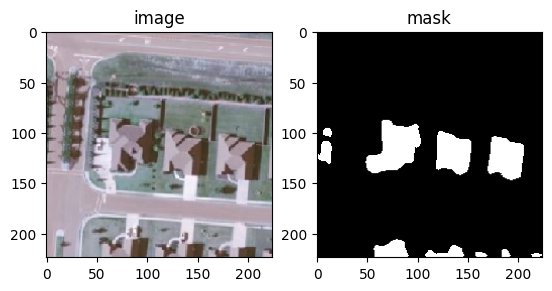

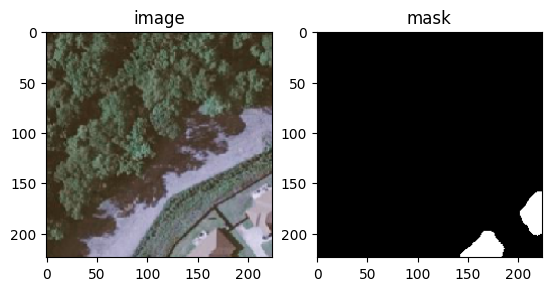

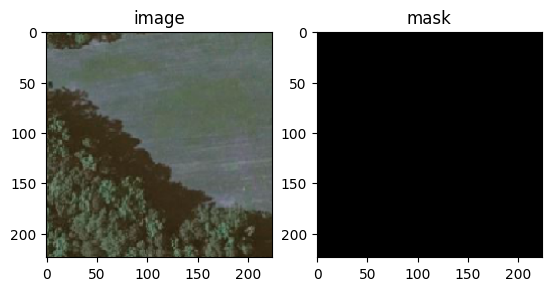

In [155]:
# Colab 사용시 활성화

last_submit = pd.read_csv(f"{colab_base}/{file_name}")
submission_viewer(test_df, last_submit, 0, colab_base, is_colab = True)
submission_viewer(test_df, last_submit, 1, colab_base, is_colab = True)
submission_viewer(test_df, last_submit, 2, colab_base, is_colab = True)

In [ ]:
# kaggle 사용시 활성화

# last_submit = pd.read_csv(f"/kaggle/working/{file_name}")
# submission_viewer(test_df, last_submit, 0, f'/kaggle/working/{file_name}', is_colab = True)
# submission_viewer(test_df, last_submit, 1, f'/kaggle/working/{file_name}', is_colab = True)
# submission_viewer(test_df, last_submit, 2, f'/kaggle/working/{file_name}', is_colab = True)

In [ ]:
# 로컬 사용시 활성화

last_submit = pd.read_csv(f"{config['base_path']}/file_name.csv")
submission_viewer(test_df, last_submit, 0)
submission_viewer(test_df, last_submit, 1)
submission_viewer(test_df, last_submit, 2)